# Naive Bayes from Scratch

- Let's implement Naive Bayes on a simple dataset

Housing data:

- Features/predictors = salary + age
- Target = house (binary, house owned or not)

In [8]:
#Get our basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


### Preliminaries

- Get the data
- Train/test split
- Apply standard scaler

In [9]:
#df = pd.read_csv('houseliving.csv') [['salary', 'age', 'house']]
df = pd.read_csv('https://raw.githubusercontent.com/seikenberry1/ML_Course/main/Lectures/Data/houseliving.csv')[['salary', 'age', 'house']]

In [10]:
#Make a train-test split:
###

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['salary', 'age']], df[['house']], test_size=.3, random_state=42)
X_train

,salary,age
389,33000.0,46
145,48695.0,41
351,54000.0,52
338,72000.0,63
109,75000.0,45
...,...,...
71,52000.0,28
106,82305.0,43
270,65305.0,58
348,97305.0,62


In [11]:
#Let's scale:
###
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

#Fit-transform
X_train_scaled = std_scaler.fit_transform(X_train)

#And transform testing:
X_test_scaled = std_scaler.transform(X_test)


#Back to DataFrame:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns,
                              index = X_train.index)

#Back to DataFrame:
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns,
                              index = X_test.index)
X_train_scaled

,salary,age
389,-1.077421,-0.049769
145,-0.657077,-0.510538
351,-0.514998,0.503153
338,-0.032922,1.516844
109,0.047424,-0.141923
...,...,...
71,-0.568562,-1.708536
106,0.243067,-0.326231
270,-0.212227,1.056075
348,0.644797,1.424690


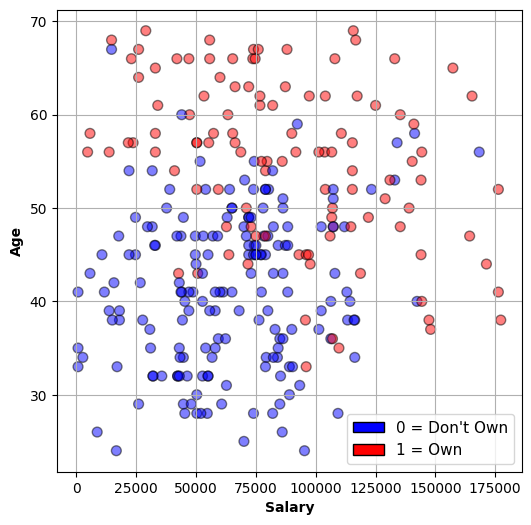

In [12]:
## And plot:
###
from matplotlib.colors import ListedColormap
my_cmap = (ListedColormap(["blue", "red"]))

fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))

#Scatter Plot, color by whether house is owned:
ax1.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c = y_train['house'], cmap=my_cmap, alpha=.5, s=50, edgecolor='black')

ax1.set_xlabel('Salary', fontweight='bold')
ax1.set_ylabel('Age', fontweight='bold')



#Custom Legend
#######

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', edgecolor='black', alpha=1, label='0 = Don\'t Own'),
                   Patch(facecolor='red', edgecolor='black', alpha=1, label='1 = Own')]

ax1.legend(handles=legend_elements, fontsize=11, loc='lower right');

ax1.grid()

## What do we need?

1. Priors: $P(Y = 0)$, $P(Y = 1)$
2. Conditional Densities

In [13]:
##Get our priors:
# We'll just get the relative frequency in the training set = our prior
vals, counts = np.unique(y_train['house'], return_counts=True)
counts

array([177, 110])

In [14]:
#So we see prior probability of owning a little under 40%
Y_Prior = counts / np.sum(counts)
Y_Prior

array([0.61672474, 0.38327526])

In [15]:
#Now, we need to estimate the conditional densities for each feature:
#Let's do separately for house = 0 vs house = 1

#We can do this because index lines up:
X_train_0 = X_train_scaled.loc[y_train.house == 0]
X_train_1 = X_train_scaled.loc[y_train.house == 1]
X_train_0

,salary,age
389,-1.077421,-0.049769
145,-0.657077,-0.510538
351,-0.514998,0.503153
109,0.047424,-0.141923
192,-1.648012,-0.510538
...,...,...
121,-0.774650,-0.786999
188,0.885835,-0.602692
71,-0.568562,-1.708536
106,0.243067,-0.326231


Text(0, 0.5, 'Density')

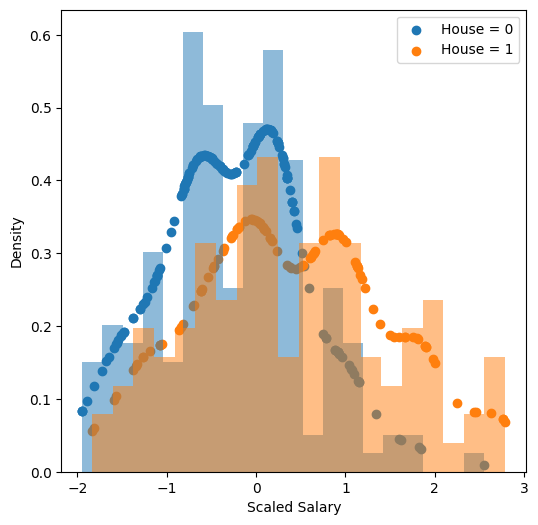

In [16]:
#Make KDEs for *salary*, conditioned on house
######

from sklearn.neighbors import KernelDensity

kde_salary_0 = KernelDensity(bandwidth=.25, kernel='gaussian')
kde_salary_0.fit(X_train_0[['salary']])

kde_salary_1 = KernelDensity(bandwidth=.25, kernel='gaussian')
kde_salary_1.fit(X_train_1[['salary']])

log_density_0 = kde_salary_0.score_samples(X_train_0[['salary']])
log_density_1 = kde_salary_1.score_samples(X_train_1[['salary']])


#Simple scatter plot to check:
######
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))

ax1.scatter(X_train_0[['salary']], np.exp(log_density_0), label='House = 0')
ax1.scatter(X_train_1[['salary']], np.exp(log_density_1), label='House = 1')

ax1.hist(X_train_0[['salary']], density=True, bins=20, alpha=.5);
ax1.hist(X_train_1[['salary']], density=True, bins=20, alpha=.5);

ax1.legend();

ax1.set_xlabel('Scaled Salary')
ax1.set_ylabel('Density')

Text(0, 0.5, 'Density')

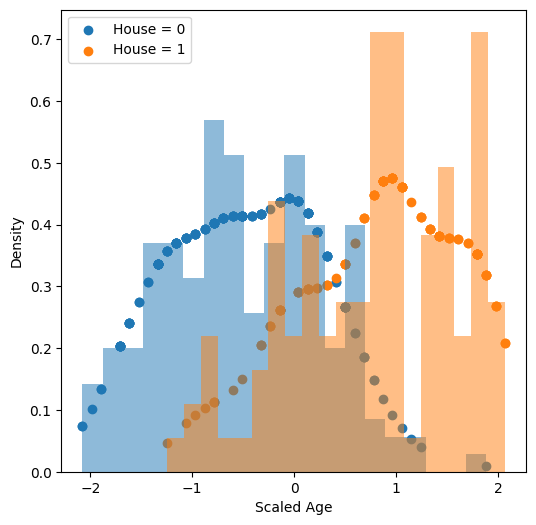

In [17]:
#Make KDEs for *age*, conditioned on house
######

kde_age_0 = KernelDensity(bandwidth=.25, kernel='gaussian')
kde_age_0.fit(X_train_0[['age']])

kde_age_1 = KernelDensity(bandwidth=.25, kernel='gaussian')
kde_age_1.fit(X_train_1[['age']])

log_density_0 = kde_age_0.score_samples(X_train_0[['age']])
log_density_1 = kde_age_1.score_samples(X_train_1[['age']])


#Scatter plot to check
########
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))

ax1.scatter(X_train_0[['age']], np.exp(log_density_0), label='House = 0')
ax1.scatter(X_train_1[['age']], np.exp(log_density_1), label='House = 1')

ax1.hist(X_train_0[['age']], density=True, bins=20, alpha=.5);
ax1.hist(X_train_1[['age']], density=True, bins=20, alpha=.5);

ax1.legend()

ax1.set_xlabel('Scaled Age')
ax1.set_ylabel('Density')

In [18]:
##Now, we have our densities and our priors
#Time to get a prediction for a given salary and age

def get_probas(salary, age):

    #Get the value of likelihood function for age and salary
    #Partitioned by house = 0 or house = 1
    age_density_0 = np.exp(kde_age_0.score_samples(age))
    salary_density_0 = np.exp(kde_salary_0.score_samples(salary))


    age_density_1 = np.exp(kde_age_1.score_samples(age))
    salary_density_1 = np.exp(kde_salary_1.score_samples(salary))

    #Probability is prior times likelihood
    prob0 = Y_Prior[0] * salary_density_0 * age_density_0
    prob1 = Y_Prior[1] * salary_density_1 * age_density_1

    #Normalize s.t. sum of probability is 1
    return prob0 / (prob0 + prob1), prob1 / (prob0 + prob1)

def get_class(salary, age):
    #Get probability
    prob_no_house, prob_house = get_probas(salary, age)

    #Convert to binary prediction
    prediction = (prob_house > prob_no_house).astype(int)

    return prediction

In [19]:
#Get our predictions on the test set:
#######

prob_no_house, prob_house = get_probas(X_test_scaled[['salary']], X_test_scaled[['age']])
house_predict = (prob_house > prob_no_house).astype(int)

In [20]:
#Accuracy?
from sklearn import metrics

metrics.accuracy_score(y_test['house'], house_predict)

0.8467741935483871

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test['house'], house_predict)
cm

array([[77,  3],
       [16, 28]])

In [22]:
print(metrics.classification_report(y_test['house'], house_predict))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        80
           1       0.90      0.64      0.75        44

    accuracy                           0.85       124
   macro avg       0.87      0.80      0.82       124
weighted avg       0.85      0.85      0.84       124



0.9426136363636364

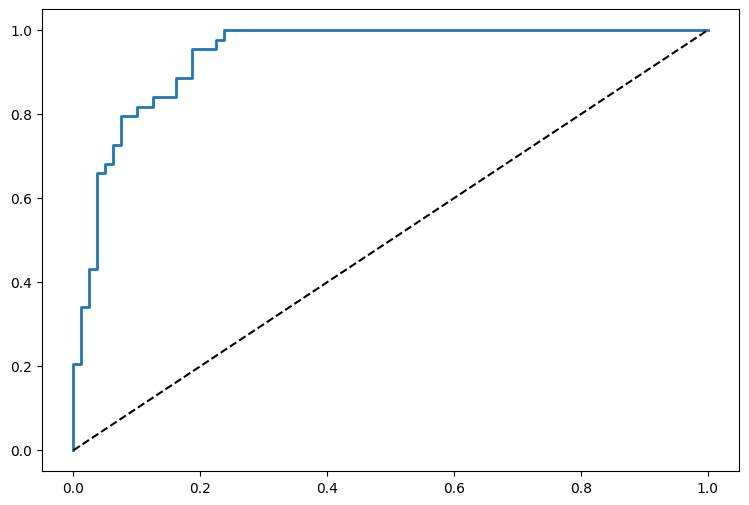

In [23]:
#Can make ROC curve with scikit-learn:
#####

from sklearn.metrics import roc_curve

#FPR is 1 - TNR
FPR, TPR, thresholds = roc_curve(y_test['house'], prob_house)

fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))

ax1.step(FPR, TPR, linewidth=2)
ax1.plot([0,1], [0,1], '--', color = 'black')


AUC = np.trapz(TPR, FPR)
AUC

In [24]:
#And precision-recall:
######

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test['house'], prob_house)

(0.0, 1.0)

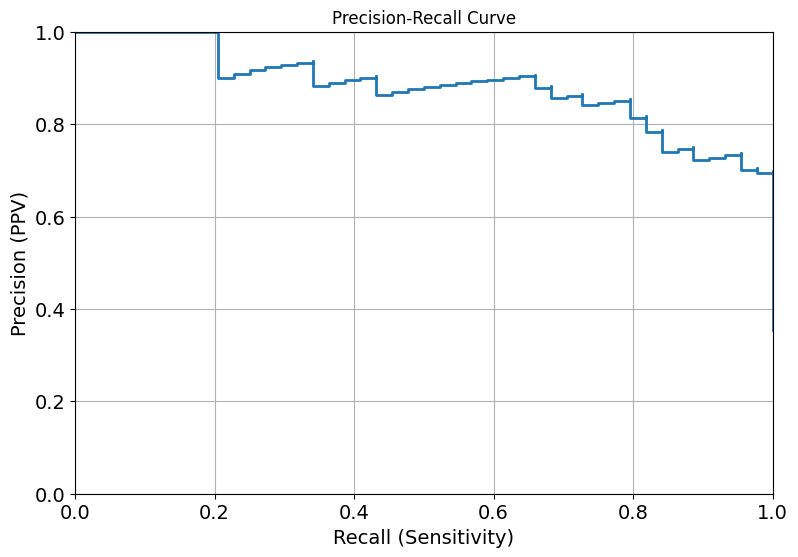

In [25]:
fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))

ax1.step(recalls, precisions, linewidth=2)
ax1.grid()

#Axis labels, etc.
fs = 14
ax1.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax1.set_ylabel('Precision (PPV)', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('Precision-Recall Curve')
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 1])


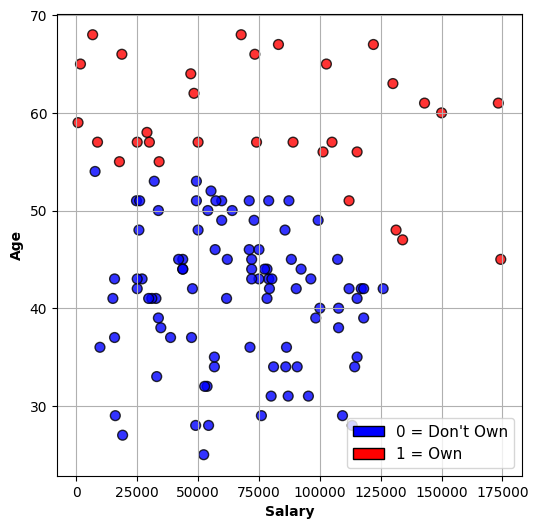

In [26]:
## And plot our predictions:
## Just plot as scatter:
###
from matplotlib.colors import ListedColormap
my_cmap = (ListedColormap(["blue", "red"]))

fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))

#ax1.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c = y_train['house'], cmap=my_cmap, alpha=.8, s=50, edgecolor='black')
ax1.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c = house_predict, cmap=my_cmap, alpha=.8, s=50, edgecolor='black')

ax1.set_xlabel('Salary', fontweight='bold')
ax1.set_ylabel('Age', fontweight='bold')


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', edgecolor='black', alpha=1, label='0 = Don\'t Own'),
                   Patch(facecolor='red', edgecolor='black', alpha=1, label='1 = Own')]

ax1.legend(handles=legend_elements, fontsize=11, loc='lower right');

ax1.grid()

In [27]:
#Range for contour:
x1 = 0; x2 = np.max(X_train['salary'])*1.025
y1 = np.min(X_train['age'])*.95; y2 = np.max(X_train['age'])*1.025

#Points for contour
N = 75

X, Y = np.meshgrid(np.linspace(x1, x2, 200),
                         np.linspace(y1, y2, 200))

#Get as Nx2:
XY_ravel = np.c_[X.ravel(), Y.ravel()]

#Rescale our points:
#Let's retrain the scaler, just in case:
scaler = StandardScaler()
scaler.fit(X_train)

XY_ravel_scaled = scaler.transform(XY_ravel)

#Get the class:
Z = get_class(XY_ravel_scaled[:,0].reshape(-1,1), XY_ravel_scaled[:,1].reshape(-1,1))

#Reshape back:
Z = Z.reshape(X.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


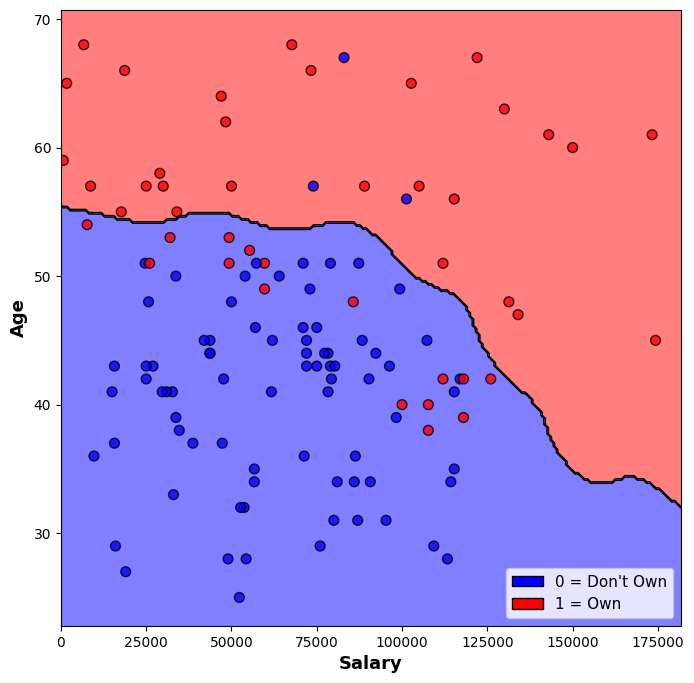

In [28]:
## And plot as prediction contours vs. truth:
###
from matplotlib.colors import ListedColormap
my_cmap = (ListedColormap(["blue", "red"]))

fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))

#Contour of predictions
ax1.contourf(X, Y, Z, 1, alpha=.5, cmap=my_cmap)

#Add nice thick line
ax1.contour(X, Y, Z, 1, alpha=1, linewidths=1, colors='black')

#Testing values:
ax1.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c = y_test['house'], cmap=my_cmap, alpha=.8, s=50, edgecolor='black')

#Or could do training values:
#ax1.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c = y_train['house'], cmap=my_cmap, alpha=.8, s=50, edgecolor='black')


#Aesthetics
ax1.set_xlabel('Salary', fontweight='bold', fontsize=13)
ax1.set_ylabel('Age', fontweight='bold', fontsize=13)


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', edgecolor='black', alpha=1, label='0 = Don\'t Own'),
                   Patch(facecolor='red', edgecolor='black', alpha=1, label='1 = Own')]

ax1.legend(handles=legend_elements, fontsize=11, loc='lower right');

# Naive Bayes Using Scikit-Learn

- Let's introduce the `GaussianNB` estimator

In [29]:
from sklearn.naive_bayes import GaussianNB

#Fit
gnb = GaussianNB()

#And train:
gnb.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [30]:
#Predictions using Gaussian NB
y_pred = gnb.predict(X_test_scaled)


In [31]:
#Our method:
print(metrics.classification_report(y_test['house'], house_predict))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89        80
           1       0.90      0.64      0.75        44

    accuracy                           0.85       124
   macro avg       0.87      0.80      0.82       124
weighted avg       0.85      0.85      0.84       124



In [32]:
#Scikit-learn:
print(metrics.classification_report(y_test['house'], y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        80
           1       0.88      0.66      0.75        44

    accuracy                           0.85       124
   macro avg       0.86      0.80      0.82       124
weighted avg       0.85      0.85      0.84       124



In [33]:
#Range for contour:
x1 = 0; x2 = np.max(X_train['salary'])*1.025
y1 = np.min(X_train['age'])*.95; y2 = np.max(X_train['age'])*1.025

#Points for contour
N = 75

X, Y = np.meshgrid(np.linspace(x1, x2, 200),
                         np.linspace(y1, y2, 200))

#Get as Nx2:
XY_ravel = np.c_[X.ravel(), Y.ravel()]

#Rescale our points:
#Let's retrain the scaler, just in case:
scaler = StandardScaler()
scaler.fit(X_train)

XY_ravel_scaled = scaler.transform(XY_ravel)

#Get the class:
Z = gnb.predict(XY_ravel_scaled)

#Reshape back:
Z = Z.reshape(X.shape)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


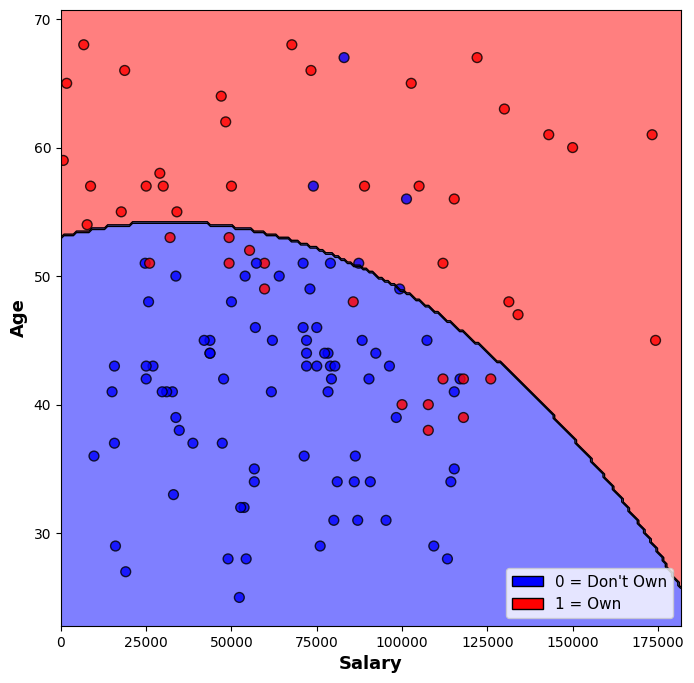

In [34]:
## And plot:
###
from matplotlib.colors import ListedColormap
my_cmap = (ListedColormap(["blue", "red"]))

fig1, ax1 = plt.subplots(1, 1, figsize=(8,8))

ax1.contourf(X, Y, Z, 1, alpha=.5, cmap=my_cmap)
ax1.contour(X, Y, Z, 1, alpha=1, linewidths=1, colors='black')

ax1.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c = y_test['house'], cmap=my_cmap, alpha=.8, s=50, edgecolor='black')

ax1.set_xlabel('Salary', fontweight='bold', fontsize=13)
ax1.set_ylabel('Age', fontweight='bold', fontsize=13)


from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', edgecolor='black', alpha=1, label='0 = Don\'t Own'),
                   Patch(facecolor='red', edgecolor='black', alpha=1, label='1 = Own')]

ax1.legend(handles=legend_elements, fontsize=11, loc='lower right');